# MobileNetV2 for Expression Recognition
## Objective
Fine-tune MobileNetV2 model to create lightweight version that is appropriate for edge devices, ensuring efficient performance in terms of speed and memory usage.

# Import the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import time

# Check if GPU is Active

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


# Load CSV into DataFrame

In [3]:
data = pd.read_csv('/kaggle/input/fer2013-facial-expression-recognition-dataset/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Check the Shape of DataFrame

In [4]:
data.shape

(35887, 3)

# Data Preprocessing

## Remove Irrelavant Columns from DataFrame

In [5]:
# Drop the specified column from the DataFrame
data = data.drop(columns=['Usage'])

# Check the updated DataFrame to ensure the column are dropped
data.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## Handle Missing/Null Values

In [6]:
# Check for missing values
data.isnull().sum()

emotion    0
pixels     0
dtype: int64

## Preprocessing the Images

In [7]:
# Convert the pixel values into images and preprocess them
def process_and_resize_pixels(pixel_string):
    # Convert the pixel string into a numpy array
    pixels = np.array(pixel_string.split(), dtype='float32')
    # Reshape the array into a 48x48 grayscale image
    pixels = pixels.reshape(48, 48)
    # Resize the image to 128x128 to reduce memory usage
    resized_image = cv2.resize(pixels, (128, 128))
    # Normalize the pixel values to [0, 1]
    normalized_image = resized_image / 255.0
    # Convert to float16 to further reduce memory usage
    return normalized_image.astype('float16')

# Apply the conversion to the 'pixels' column
data['preprocessed_image'] = data['pixels'].apply(process_and_resize_pixels)

In [8]:
data.head()

,emotion,pixels,preprocessed_image
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,"[[0.2744, 0.2769, 0.2917, 0.3064, 0.3152, 0.31..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,"[[0.5923, 0.592, 0.5903, 0.589, 0.586, 0.5815,..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,"[[0.906, 0.9014, 0.873, 0.845, 0.79, 0.708, 0...."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,"[[0.0941, 0.09607, 0.10785, 0.1196, 0.1284, 0...."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,"[[0.01569, 0.01471, 0.00883, 0.002941, 0.0, 0...."


# Visualizing the Images

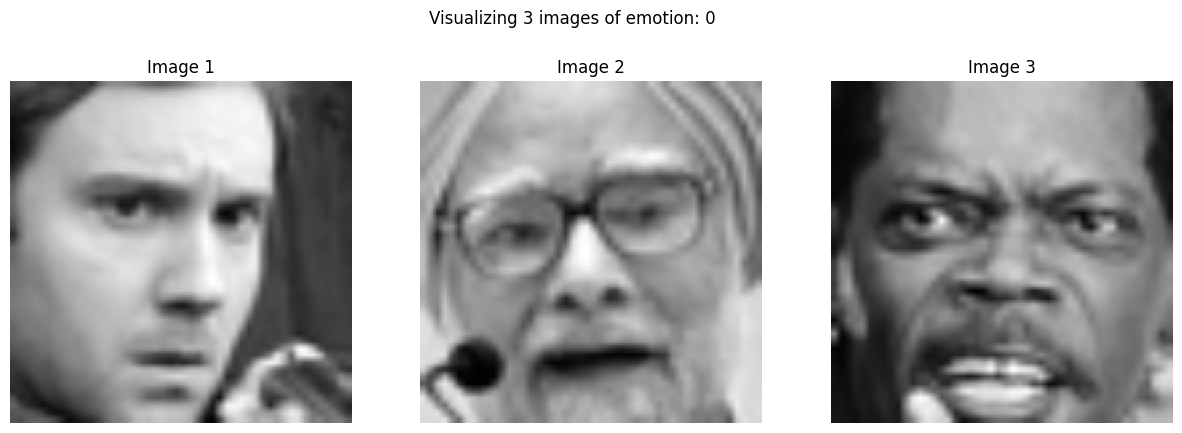

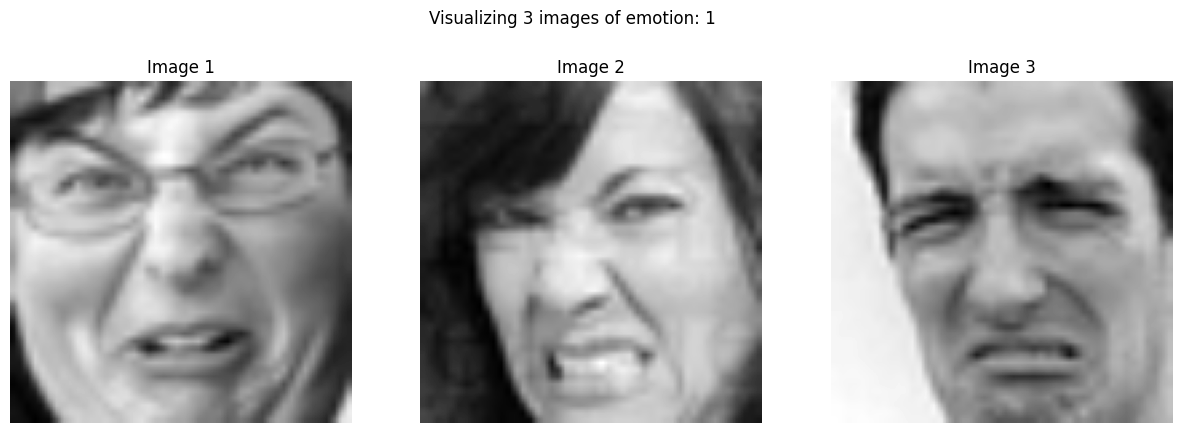

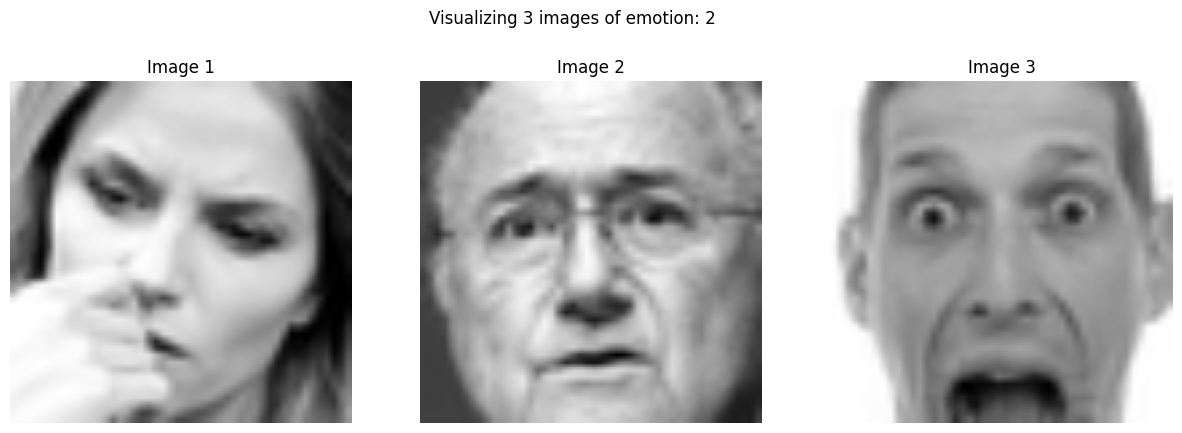

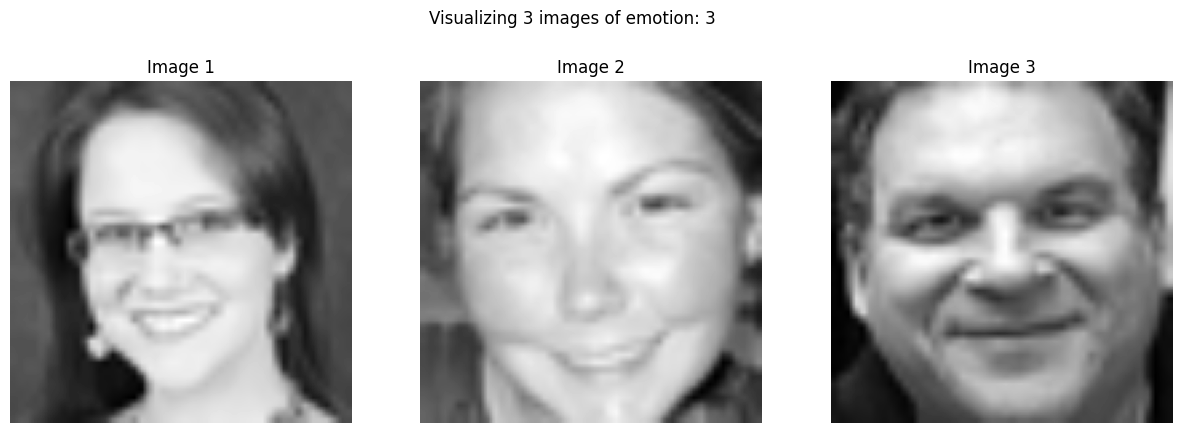

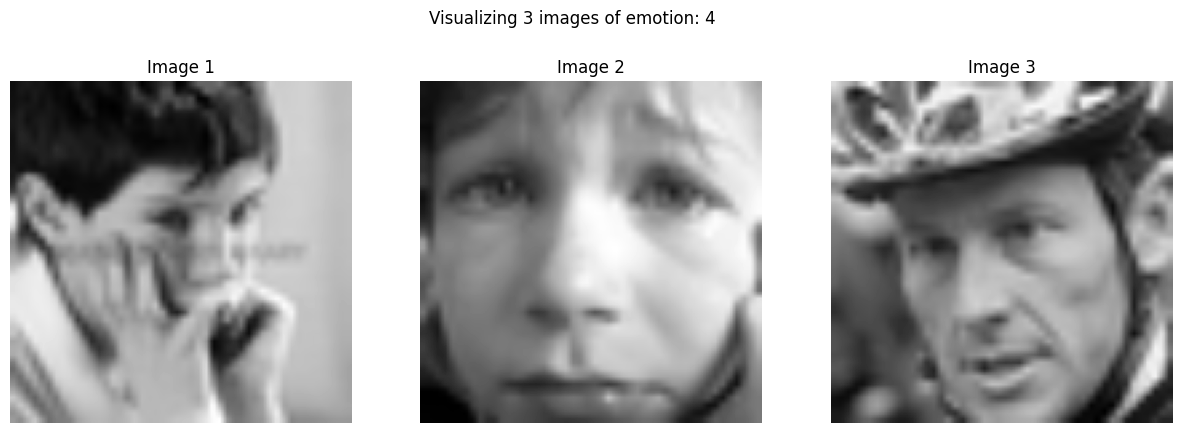

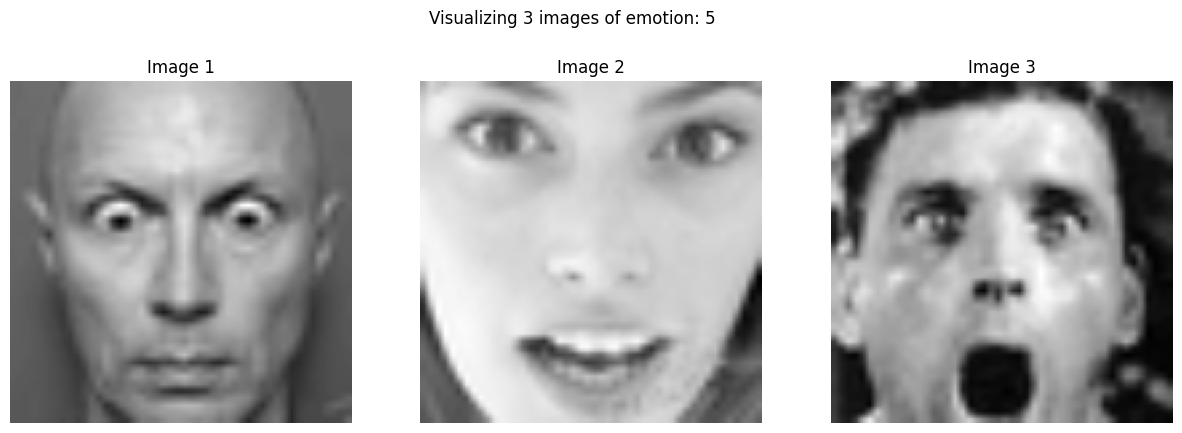

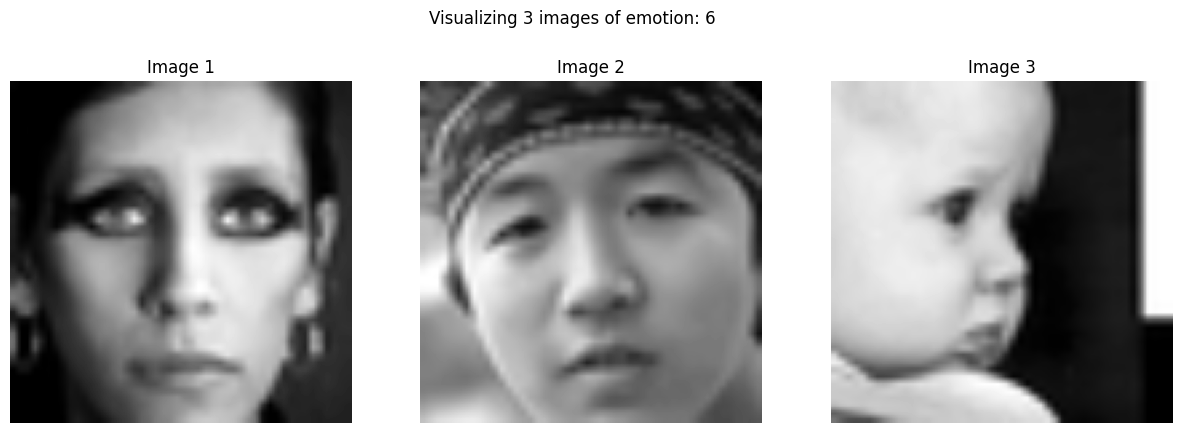

In [9]:
# Function to visualize a few images for each emotion category
def visualize_emotion_images(df, emotion_label, num_images=3):
    # Filter the DataFrame for the selected emotion category
    emotion_df = df[df['emotion'] == emotion_label].head(num_images)
    
    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(f'Visualizing {num_images} images of emotion: {emotion_label}')
    
    for i, (index, row) in enumerate(emotion_df.iterrows()):
        axes[i].imshow(row['preprocessed_image'], cmap='gray')  # FER2013 images are grayscale
        axes[i].axis('off')  # Remove axis for clarity
        axes[i].set_title(f'Image {i+1}')
    
    plt.show()

# Visualize 3 images for each emotion category
emotion_labels = {
    0: 'Anger',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

for label, emotion in emotion_labels.items():
    visualize_emotion_images(data, label, num_images=3)

# Verify the Distribution of Labels

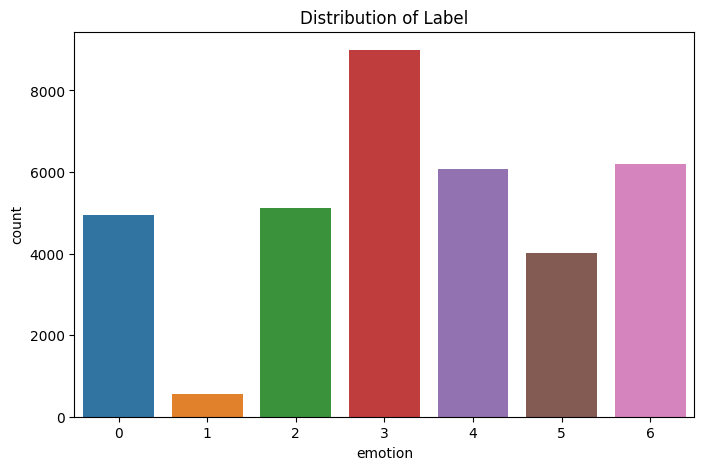

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(x='emotion', data=data)
plt.title('Distribution of Label')
plt.show()

# Splitting the DataFrame

In [11]:
# Prepare the image data (X) and emotion labels (y_emotion)
X = np.array(data['preprocessed_image'].tolist()).astype('float16') 
y_emotion = np.array(data['emotion'].tolist())

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train_emotion, y_temp_emotion = train_test_split(
    X, y_emotion, test_size=0.30, random_state=42
)
X_val, X_test, y_val_emotion, y_test_emotion = train_test_split(
    X_temp, y_temp_emotion, test_size=0.50, random_state=42
)

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}, Test data: {X_test.shape}")
print(f"Training labels: {y_train_emotion.shape}, Validation labels: {y_val_emotion.shape}, Test labels: {y_test_emotion.shape}")

Training data: (25120, 128, 128), Validation data: (5383, 128, 128), Test data: (5384, 128, 128)
Training labels: (25120,), Validation labels: (5383,), Test labels: (5384,)


# Fine-Tuning MobileNet

## Building MobileNetV2 Model

In [13]:
# Load the MobileNetV2 model with input shape for grayscale images
base_model = MobileNetV2(input_shape=(128, 128, 1), include_top=False, weights=None)

# Add the custom layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

# Output layer for emotion classification
emotion_output = layers.Dense(7, activation='softmax', name='emotion_output')(x)

# Define the new model
model = models.Model(inputs=base_model.input, outputs=emotion_output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',  # Sparse Categorical Crossentropy for multi-class classification
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,266,375 (8.65 MB)

 Trainable params: 2,232,263 (8.52 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Train the Model

In [14]:
history = model.fit(
    X_train, y_train_emotion, validation_data=(X_val, y_val_emotion),  
    epochs=10,  batch_size=32  
)

Epoch 1/10


I0000 00:00:1728753236.137327     543 service.cc:145] XLA service 0x7ba94c234880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728753236.137377     543 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728753236.137380     543 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/785 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.1753 - loss: 2.1029 

I0000 00:00:1728753252.211998     543 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


785/785 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.2331 - loss: 1.8360 - val_accuracy: 0.1683 - val_loss: 1.8837
Epoch 2/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.2800 - loss: 1.7532 - val_accuracy: 0.1683 - val_loss: 1.8753
Epoch 3/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.3418 - loss: 1.6660 - val_accuracy: 0.1683 - val_loss: 1.9199
Epoch 4/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.3888 - loss: 1.5630 - val_accuracy: 0.1683 - val_loss: 2.0089
Epoch 5/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.4332 - loss: 1.4638 - val_accuracy: 0.1648 - val_loss: 2.1236
Epoch 6/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.4820 - loss: 1.3616 - val_accuracy: 0.1648 - val_loss: 2.1648
Epoch 7/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.5218 - loss: 1.2601 - val_accuracy: 0.1650 - val_loss: 2.1608
Epoch 8/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.5801 - loss: 1.1278 - val_accurac

## Evaluate the Model

### Plotting Training and Validation Accuracy and Loss

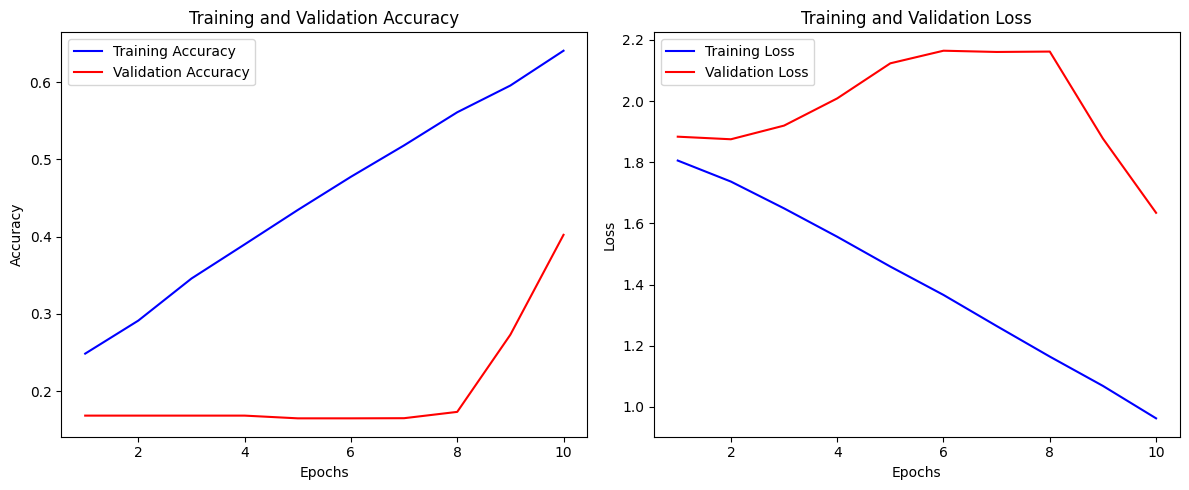

In [15]:
def plot_training_history(history):
    # Extract values from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_training_history(history)

### Evaluate the model on test data

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_emotion, batch_size=32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3944 - loss: 1.6611
Test Loss: 1.6166908740997314
Test Accuracy: 0.40453195571899414


### Confusion Matrix

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


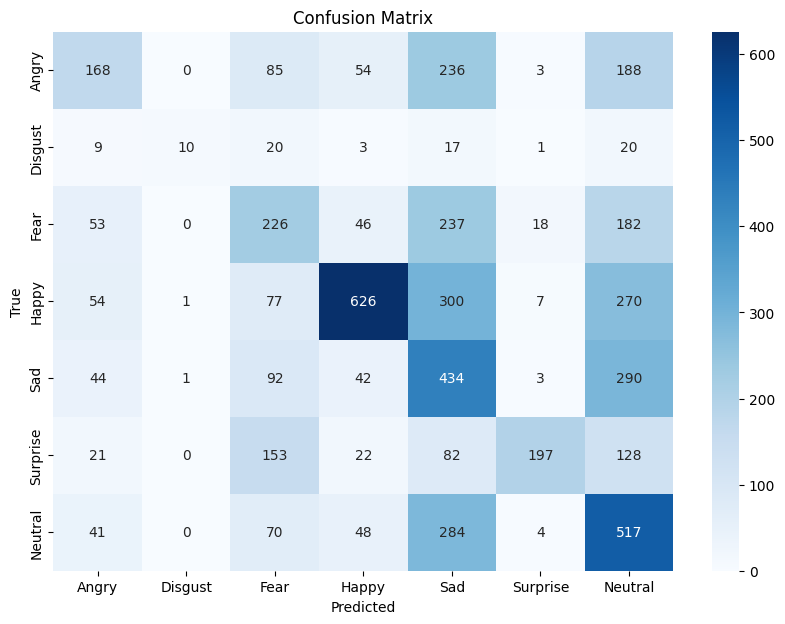

In [20]:
# Predict the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_test_emotion directly
y_true = y_test_emotion  

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Class names
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Classification report

In [21]:
# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Display the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       Angry       0.43      0.23      0.30       734
     Disgust       0.83      0.12      0.22        80
        Fear       0.31      0.30      0.30       762
       Happy       0.74      0.47      0.58      1335
         Sad       0.27      0.48      0.35       906
    Surprise       0.85      0.33      0.47       603
     Neutral       0.32      0.54      0.40       964

    accuracy                           0.40      5384
   macro avg       0.54      0.35      0.37      5384
weighted avg       0.50      0.40      0.41      5384



### Evaluate Inference Time

In [22]:
# Select a small sample of test data to measure inference time
sample_size = 100
X_sample = X_test[:sample_size]

# Measure inference time
start_time = time.time()
_ = model.predict(X_sample)
end_time = time.time()

# Calculate and print the average inference time per sample
inference_time = (end_time - start_time) / sample_size
print(f"Average inference time per sample: {inference_time:.6f} seconds")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 728ms/step
Average inference time per sample: 0.022911 seconds


### Check Memory Usage

In [23]:
# Get total trainable parameters
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])

# Calculate memory usage in bytes (float32 -> 4 bytes per parameter)
memory_usage_bytes = trainable_params * 4  # 4 bytes per float32
memory_usage_mb = memory_usage_bytes / (1024 ** 2)  # Convert to MB

print(f"Model memory usage: {memory_usage_mb:.2f} MB")

Model memory usage: 8.52 MB


## Save the Model

In [24]:
# Save the Keras model as an .h5 file
model.save('Original_MobileNet_Expression.h5')

# Provide a download link to the .h5 file
from IPython.display import FileLink

# Display a download link
FileLink('Original_MobileNet_Expression.h5')

/kaggle/working/Original_MobileNet_Expression.h5